## Healthcare Analytics:

Things to test out:
* Try XGB and LGB ratio ensemble
* More date features

Observations:
* We have to combine the 3 type csv files and the health camp csv with the train csv
* The data in the patient df is mostly missing values so it's better to not use them

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lightgbm as lgb
import xgboost as xgb
import tqdm
import datetime
from sklearn.metrics import roc_auc_score

# Files we have
!ls Train

Data_Dictionary.xlsx
First_Health_Camp_Attended.csv
Health_Camp_Detail.csv
Patient_Profile.csv
Second_Health_Camp_Attended.csv
Third_Health_Camp_Attended.csv
Train.csv


In [344]:
train_data = pd.read_csv('./Train/Train.csv')
patient = pd.read_csv('./Train/Patient_Profile.csv')
camp_info = pd.read_csv('./Train/Health_Camp_Detail.csv')
test_data = pd.read_csv('test.csv')

first_type_data = pd.read_csv('./Train/First_Health_Camp_Attended.csv')
second_type_data = pd.read_csv('./Train/Second_Health_Camp_Attended.csv')
third_type_data = pd.read_csv('./Train/Third_Health_Camp_Attended.csv')

In [345]:
# date needs some filling
print(train_data.isnull().sum())
train_data['Registration_Date'] = train_data['Registration_Date'].fillna('28-Mar-06')

Patient_ID             0
Health_Camp_ID         0
Registration_Date    334
Var1                   0
Var2                   0
Var3                   0
Var4                   0
Var5                   0
dtype: int64


In [346]:
def clean_patient(df):
    # too many missing values for these columns
    #df.drop(['Age', 'Education_Score', 'Income'], axis=1, inplace=True)
    df.drop(['Online_Follower','LinkedIn_Shared','Twitter_Shared','Facebook_Shared'], axis=1, inplace=True)
    #df.drop('First_Interaction', axis=True, inplace=True)
    #df.drop(['First_Interaction', 'City_Type', 'Employer_Category'], axis=1, inplace=True)
    df[['Income', 'Education_Score', 'Age']] = df[['Income', 'Education_Score', 'Age']].apply(lambda x: x.str.replace('None', 'NaN').astype('float'))
    
    #df['Age'] = df['Age'].fillna(df['Age'].median())
    #df['Income'] = df['Income'].fillna(df['Age'].median())
    #df['Education_Score'] = df['Education_Score'].fillna(df['Age'].median())
    df[['City_Type', 'Employer_Category']] = df[['City_Type', 'Employer_Category']].apply(lambda x: pd.factorize(x)[0])    
    #df = df.fillna(-99)
    return df

# cleaning camp data
def clean_camp(health_camp):
    health_camp['Category1'] = health_camp['Category1'].map({'First': 1, 'Second': 2, 'Third': 3})
    health_camp['Category2'] = pd.factorize(health_camp['Category2'])[0]
    health_camp.drop('Category3', axis=1, inplace=True)
    health_camp['Camp_Start_Date'] = pd.to_datetime(health_camp['Camp_Start_Date'])
    health_camp['Camp_End_Date'] = pd.to_datetime(health_camp['Camp_End_Date'])
    health_camp['total_days_of_campaign'] = (health_camp['Camp_End_Date'] - health_camp['Camp_Start_Date']).dt.days
    return health_camp
    #return health_camp.drop(['Camp_Start_Date', 'Camp_End_Date'], axis=1)

def combine_patient(df):
    return df.join(patient.set_index('Patient_ID'), on='Patient_ID', how='left')

def combine_camp(df):
    return df.join(camp_info.set_index('Health_Camp_ID'), on='Health_Camp_ID', how='left')  

In [347]:
# code adapted from https://colab.research.google.com/drive/1aHNlBeBGa06hSYXRklQsVW6WAYv0-qRM?usp=sharing
patient = clean_patient(patient)

for df in [first_type_data, second_type_data, third_type_data, train_data]:
    df['id'] = df['Patient_ID'].astype('str') + df['Health_Camp_ID'].astype('str')
    
third_type_data = third_type_data[third_type_data['Number_of_stall_visited'] > 0]

all_patients_in_camp = pd.Series(first_type_data['id'].tolist() 
                                 + second_type_data['id'].tolist()
                                 + third_type_data['id'].tolist()).unique()

train_data['target'] = 0
train_data.loc[train_data['id'].isin(all_patients_in_camp), 'target'] = 1
train_data = train_data.drop('id', axis=1)

In [348]:
train_data = combine_patient(train_data)
test_data = combine_patient(test_data)
camp_info = clean_camp(camp_info)
train_data = combine_camp(train_data)
test_data = combine_camp(test_data)

In [349]:
# generating clean train and test sets
def clean_dates(x):
    y = x.sort_values('Registration_Date')
    return y.diff()

def clean_data(df, train=True):
    df['Registration_Date'] = pd.to_datetime(df['Registration_Date'])
    df['First_Interaction'] = pd.to_datetime(df['First_Interaction'])
    df['Reg_First'] = (df['Registration_Date'] - df['First_Interaction']).dt.days
    df['Days_From_Start'] = (df['Registration_Date'] - df['Camp_Start_Date']).dt.days
    df['Days_From_End'] = (df['Camp_End_Date'] - df['Registration_Date']).dt.days
    df['Days_For_Interaction'] =  (df['First_Interaction'] - df['Camp_Start_Date']).dt.days
    
    gby = df.groupby('Patient_ID').apply(clean_dates)
    rt = gby['Registration_Date'].fillna(datetime.timedelta(days=500)).reset_index().drop('Patient_ID', axis=1).set_index('level_1')
    df.index.name = 'level_1'
    rt = rt.rename(columns={'Registration_Date': 'diff'})
    df = rt.merge(df, on='level_1', how='left').sort_values(by='level_1')    
    #df['date_diff'] = gby['Registration_Date'].fillna(datetime.timedelta(days=500)) \
    #                 .reset_index()['Registration_Date'].dt.days
    df['diff'] = df['diff'].dt.days
    count_map = dict(df.groupby('Patient_ID').agg({'Health_Camp_ID': 'count'}).reset_index().values)
    df['Num_Camps'] = df['Patient_ID'].map(count_map)
    df['Donated'] = 0
    for id_ in first_type_data['Patient_ID']:
        df.loc[df.Patient_ID == id_, 'Donated'] = float(first_type_data[first_type_data.Patient_ID == id_]['Donation'].mean())
    if train:
        df.drop(['Patient_ID', 'Health_Camp_ID'], axis=1, inplace=True)
    return df.drop(['Camp_Start_Date', 'Camp_End_Date'], axis=1)

In [350]:
train_data = clean_data(train_data)
test_data = clean_data(test_data, False)

#print(pearsonr(train_data['target'], train_data['donated']))

In [351]:
#train_data['diff'] = train_data['diff'].dt.days
#test_data['diff'] = test_data['diff'].dt.days

In [362]:
# generating split that's close to test data split

min_test_date = test_data['Registration_Date'].min()
train = train_data.drop('target', axis=1)

feature_names = list(train.columns)
feature_names.remove('Registration_Date')
feature_names.remove('First_Interaction')

X_train = train[train['Registration_Date'] < min_test_date].drop(['Registration_Date', 'First_Interaction'], axis=1).values
X_val = train[train['Registration_Date'] >= min_test_date].drop(['Registration_Date', 'First_Interaction'], axis=1).values

y_train = train_data[train_data['Registration_Date'] < min_test_date]['target'].values
y_val = train_data[train_data['Registration_Date'] >= min_test_date]['target'].values

X_test = test_data.drop(['Registration_Date', 'First_Interaction'], axis=1)

In [365]:
X_train = train.drop(['Registration_Date', 'First_Interaction'], axis=1).values
y_train = train_data['target'].values

#X_val = train.drop(['Registration_Date', 'First_Interaction'], axis=1).values

[5]	valid_0's auc: 0.860934
[10]	valid_0's auc: 0.859477
0.8751531300275626
0.8594774550474958


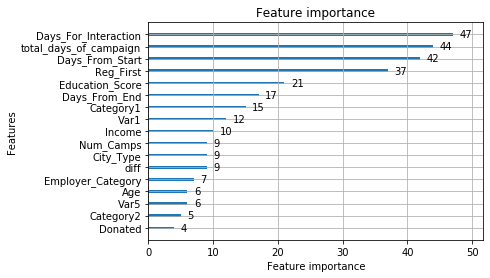

In [366]:
train_set = lgb.Dataset(X_train, y_train)
val_set = lgb.Dataset(X_val, y_val)

params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.001,
    'max_depth': 6,
    'colsample_bytree': 0.4,
    'min_child_weight': 3
}

model = lgb.train(train_set=train_set, 
                  valid_sets=val_set, 
                  params=params, 
                  verbose_eval=5, 
                  num_boost_round=10, 
                  feature_name=feature_names)

print(roc_auc_score(y_train, model.predict(X_train)))
print(roc_auc_score(y_val, model.predict(X_val)))

lgb.plot_importance(model)

[0]	eval-auc:0.87472
[9]	eval-auc:0.87594
0.9135292155784034
0.8759414571974714


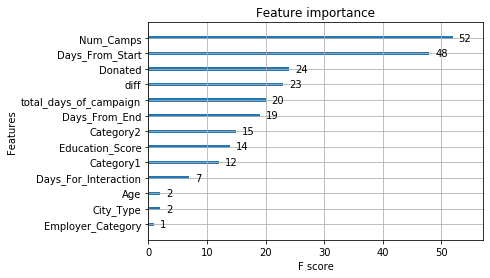

In [284]:
train_set_xg = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
val_set_xg = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

params_xg ={
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'verbosity': 1,
    'max_depth': 5,
    'subsample': 0.8,
    'eta': 0.01
}

model_xg = xgb.train(params_xg, train_set_xg, 
                  num_boost_round=10, 
                  evals=[[val_set_xg, 'eval']],
                  verbose_eval=10)

print(roc_auc_score(y_train, model_xg.predict(train_set_xg)))
print(roc_auc_score(y_val, model_xg.predict(val_set_xg)))

xgb.plot_importance(model_xg)

In [361]:
sub = pd.DataFrame()
sub['Patient_ID'] = X_test['Patient_ID']
sub['Health_Camp_ID'] = X_test['Health_Camp_ID']

#sub['Outcome'] = model_xg.predict(xgb.DMatrix(X_test.drop(['Patient_ID', 'Health_Camp_ID'], axis=1).values, feature_names=feature_names))
sub['Outcome'] = model.predict(X_test.drop(['Patient_ID', 'Health_Camp_ID'], axis=1).values)

sub.to_csv('submission.csv', index=False)

In [1221]:
'''
0.8212 params
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 6,
    'colsample_bytree': 0.4,
    'min_child_weight': 2
}
num rounds 5
best score:
[5]	valid_0's auc: 0.854756
0.8769541119255982
0.8547559525111879


0.8239
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.015,
    'max_depth': 6,
    'colsample_bytree': 0.4,
    'min_child_weight': 3
}

model = lgb.train(train_set=train_set, 
                  valid_sets=val_set, 
                  params=params, 
                  verbose_eval=5, 
                  num_boost_round=15, 
                  feature_name=feature_names)
[5]	valid_0's auc: 0.856384
[10]	valid_0's auc: 0.859264
[15]	valid_0's auc: 0.866988
0.9022561593569276
0.8669884457385031
'''

"\n0.8212 params\nparams = {\n    'boosting_type': 'dart',\n    'objective': 'binary',\n    'seed': 42,\n    'metric': 'auc',\n    'learning_rate': 0.01,\n    'max_depth': 6,\n    'colsample_bytree': 0.4,\n    'min_child_weight': 2\n}\nnum rounds 5\nbest score:\n[5]\tvalid_0's auc: 0.854756\n0.8769541119255982\n0.8547559525111879\n\n\n0.8239\nparams = {\n    'boosting_type': 'dart',\n    'objective': 'binary',\n    'seed': 42,\n    'metric': 'auc',\n    'learning_rate': 0.015,\n    'max_depth': 6,\n    'colsample_bytree': 0.4,\n    'min_child_weight': 3\n}\n\nmodel = lgb.train(train_set=train_set, \n                  valid_sets=val_set, \n                  params=params, \n                  verbose_eval=5, \n                  num_boost_round=15, \n                  feature_name=feature_names)\n[5]\tvalid_0's auc: 0.856384\n[10]\tvalid_0's auc: 0.859264\n[15]\tvalid_0's auc: 0.866988\n0.9022561593569276\n0.8669884457385031\n"